# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import time

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append(".")
#from object_detection.utils import ops as utils_ops

#if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
#    raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


# Model preparation 

### Variables

In [2]:
#Inference configs
IMAGE_PATH = 'C:/Users/jreuber/OneDrive - COMPUTACENTER/Pictures/CC Sharks'
DESTINATION_PATH = 'C:/Users/jreuber/OneDrive - COMPUTACENTER/Pictures/Samples'
IMAGE_DIMS = [300, 300]
FIGURE_DIMS = tuple(IMAGE_DIMS.copy())
BATCH_NUM = 2
THRESHOLD = 20

# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03'
MODEL_FILE = MODEL_NAME + '.tar.gz'
INFERENCE_GRAPH_PATH = MODEL_NAME + '/frozen_inference_graph.pb'

#Download url
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

VISUALIZE = True

### Model download

In [3]:
if not os.path.isfile(MODEL_FILE):
    print("Downloading model file")
    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
else:
    print("Model file already exists")
    
if not os.path.isfile(INFERENCE_GRAPH_PATH):
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())
else:
    print('Model file already extracted')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [4]:
CATEGORY_INDEX = {}
f = open("object_detection/mscoco_label_map.pbtxt", "r")
for line in f:
    if 'item' in line:
        name = f.readline().split()[1]
        real_id = int(f.readline().split()[1])
        real_name = f.readline().split()[1]
        CATEGORY_INDEX[real_id] =  {'id': real_id, 'name': real_name}

In [5]:
print(CATEGORY_INDEX)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic'}, 11: {'id': 11, 'name': 'fire'}, 13: {'id': 13, 'name': 'stop'}, 14: {'id': 14, 'name': 'parking'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name': 'frisbee'}, 35: {'id': 

### Create dataset as tensors

In [6]:
def create_dataset(path, image_dims, batch_size = 32):
    import pathlib 
    import random 
    print(image_dims)

    
    data_root = pathlib.Path(path)
    image_uris = list(data_root.glob('**/*.jpg'))
    image_uris = [str(image) for image in image_uris]
    
    def preprocess_image(image):

        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize_image_with_pad(image, image_dims[0], image_dims[1])
        #image /= 255  # normalize to [0,1] range

        return image
    
    def load_and_preprocess_image(path):
        
        image = tf.read_file(path)
        
        return preprocess_image(image)
    
    path_ds = tf.data.Dataset.from_tensor_slices(image_uris)
    #AUTOTUNE = tf.data.experimental.AUTOTUNE
    image_ds = path_ds.map(load_and_preprocess_image)
    
    return image_ds

### Create graph and connect tensors

In [7]:
def build_inference_graph(inference_graph_path):
    """Loads the inference graph and connects it to the input image.
    Args:
    image_tensor: The input image. uint8 tensor, shape=[1, None, None, 3]
    inference_graph_path: Path to the inference graph with embedded weights
    Returns:
    detected_boxes_tensor: Detected boxes. Float tensor,
        shape=[num_detections, 4]
    detected_scores_tensor: Detected scores. Float tensor,
        shape=[num_detections]
    detected_labels_tensor: Detected labels. Int64 tensor,
        shape=[num_detections]
    """
    with tf.gfile.Open(inference_graph_path, 'rb') as graph_def_file:
        graph_content = graph_def_file.read()
    graph_def = tf.GraphDef()
    graph_def.MergeFromString(graph_content)

    tf.import_graph_def(graph_def, name='')

    g = tf.get_default_graph()
    
    tensor_dict = {}
    for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
        tensor_name = key + ':0'
        try:
            tensor_dict[key] = g.get_tensor_by_name(tensor_name)
        except:
            print("Something went horribly wrong when loading graph tensors")
            pass
        
    
    image_tensor = g.get_tensor_by_name('image_tensor:0')
    print(image_tensor)
    return tensor_dict, image_tensor

# Threaded visualization

In [9]:
from threading import Thread
from object_detection.utils import visualization_utils as vis_util

def threaded_function(image_np, args_dict, counter):
    boxes = args_dict['detection_boxes']
    scores = args_dict['detection_scores']
    classes = np.array(output_dict['detection_classes'], np.int16)
    
    for i in range(BATCH_NUM):
        new_img = np.array(image_np[i], np.uint8)
        vis_util.visualize_boxes_and_labels_on_image_array(
          new_img,
          boxes[i],
          classes[i],
          scores[i],
          CATEGORY_INDEX,
          use_normalized_coordinates=True,
          line_thickness=8)
        plt.figure(figsize=FIGURE_DIMS)
        plt.imsave(DESTINATION_PATH + '/{}_{}.jpg'.format(str(counter), str(i)), new_img)
        plt.close()

# Actual Inference

[300, 300]
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Reading input from files and connecting to graph
INFO:tensorflow:Reading graph and building model
Tensor("image_tensor:0", shape=(?, ?, ?, 3), dtype=uint8)
Step: 1
Time required for reading: 0.5119497776031494
Time required for computation: 7.033600091934204
Step: 2
Time required for reading: 0.009979486465454102
Time required for computation: 0.17963099479675293
Step: 3
Time required for reading: 0.0
Time required for computation: 0.2514960765838623
Step: 4
Time required for reading: 0.006986141204833984
Time required for computation: 0.23851370811462402
Step: 5
Time required for reading: 0.0019958019256591797
Time required for computation: 0.18262696266174316
Step: 6
Time required for reading: 0.009979486465454102
Time required for computation: 0.18362712860107422
Step: 7
Time required for reading: 0.04989743232727051
Time required for computation: 0.1856241226196289
Step: 8
Time requir

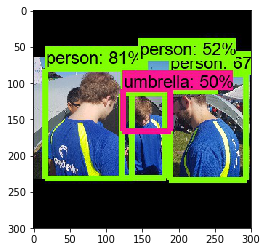

Step: 21
Time required for reading: 0.009979486465454102
Time required for computation: 0.17963099479675293
Step: 22
Time required for reading: 0.0
Time required for computation: 0.2684590816497803
Step: 23
Time required for reading: 0.009979963302612305
Time required for computation: 0.22355198860168457
Step: 24
Time required for reading: 0.0019960403442382812
Time required for computation: 0.31137585639953613
Step: 25
Time required for reading: 0.4620647430419922
Time required for computation: 0.19660019874572754
Step: 26
Time required for reading: 0.46604466438293457
Time required for computation: 0.16965150833129883
Step: 27
Time required for reading: 0.5678620338439941
Time required for computation: 0.1946086883544922
Step: 28
Time required for reading: 0.7205514907836914
Time required for computation: 0.18063807487487793
Step: 29
Time required for reading: 0.7484991550445557
Time required for computation: 0.18262791633605957
Step: 30
Time required for reading: 0.7834036350250244


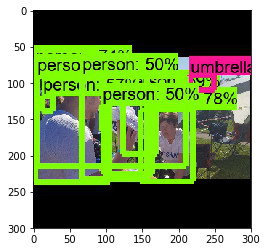

Step: 41
Time required for reading: 0.16765689849853516
Time required for computation: 0.17164897918701172
Step: 42
Time required for reading: 0.6966042518615723
Time required for computation: 0.1626737117767334
Step: 43
Time required for reading: 0.5908050537109375
Time required for computation: 0.1536850929260254
Step: 44
Time required for reading: 0.5748209953308105
Time required for computation: 0.16665911674499512
Step: 45
Time required for reading: 0.604759931564331
Time required for computation: 0.15967226028442383
Step: 46
Time required for reading: 0.5448813438415527
Time required for computation: 0.14969229698181152
Step: 47
Time required for reading: 0.5039658546447754
Time required for computation: 0.20957732200622559
Step: 48
Time required for reading: 0.5099582672119141
Time required for computation: 0.1616678237915039
Step: 49
Time required for reading: 0.511953592300415
Time required for computation: 0.219559907913208
Step: 50
Time required for reading: 0.61576366424560

KeyboardInterrupt: 

In [10]:
ds = create_dataset(IMAGE_PATH, IMAGE_DIMS)
ds = ds.prefetch(BATCH_NUM*2).batch(BATCH_NUM)
it = ds.make_one_shot_iterator()

# This is needed to display the images.
%matplotlib inline

with tf.Session() as sess:
    tf.logging.info('Reading input from files and connecting to graph')
    #image_tensor = build_input(image_path)
    
    tf.logging.info('Reading graph and building model')
    tensor_dict, image_tensor = build_inference_graph(INFERENCE_GRAPH_PATH)
    
    sess.run(tf.local_variables_initializer())
    image_it = it.get_next()
    
    threads = []
    i = 1
    j = 1
    try:
        while True:
            print('Step: ' + str(i))
            start = time.time()
            with tf.device('/gpu:0'):
                
                image = sess.run(image_it)
                print('Time required for reading: ' + str(time.time() - start))

                start = time.time()
                output_dict = sess.run(tensor_dict, feed_dict = {image_tensor: image})
                print('Time required for computation: ' + str(time.time() - start))
            
            if VISUALIZE:
                thread = Thread(target = threaded_function, args = (image, output_dict, i))
                thread.start()
                threads.append(thread)
            
            if (i % THRESHOLD == 0):
                img = plt.imread(DESTINATION_PATH + '/' + str(j) + '_0.jpg')
                plt.imshow(img)
                plt.show()
                plt.close()
                j += 1
                
            i += 1
            
                
    
    except tf.errors.OutOfRangeError:
        tf.logging.info('Finished processing records')
        for t in threads:
            t.join()